# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf, open_dict
%load_ext autoreload
%autoreload 2

import breaching

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=[])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type honest_but_curious.


{'device': device(type='cuda', index=0), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [21]:
with open_dict(cfg):
    cfg.case.user.data_idx = 1200
    cfg.case.user.data_with_labels = 'unique'

    cfg.case.user.num_data_points = 1

    cfg.case.model='resnet18'
    cfg.attack.objective.type = 'pearlmutter-cosine' #'cosine-similarity' #'pearlmutter-loss'

    cfg.attack.objective.scale = 1
    cfg.attack.objective.level_gradients = False
    cfg.attack.normalize_gradients = False
    cfg.attack.objective.eps=1e-3

    cfg.attack.optim.signed=False
    cfg.attack.restarts.num_trials = 1
    cfg.attack.optim.max_iterations = 1
    
    cfg.attack.impl.dtype = 'float64'
    # cfg.attack.impl.mixed_precision=False
    # cfg.attack.impl.JIT = 'trace'
cfg.attack

{'type': 'invertinggradients', 'attack_type': 'optimization', 'label_strategy': 'bias-corrected', 'objective': {'type': 'pearlmutter-cosine', 'scale': 1, 'task_regularization': 0.0, 'level_gradients': False, 'eps': 0.001}, 'restarts': {'num_trials': 1, 'scoring': 'cosine-similarity'}, 'init': 'randn', 'normalize_gradients': False, 'optim': {'optimizer': 'adam', 'signed': False, 'step_size': 0.1, 'boxed': True, 'max_iterations': 1, 'step_size_decay': 'step-lr', 'langevin_noise': 0.0, 'warmup': 0, 'callback': 1000}, 'regularization': {'total_variation': {'scale': 0.2, 'inner_exp': 1, 'outer_exp': 1}}, 'impl': {'dtype': 'float64', 'mixed_precision': False, 'JIT': None}}

### Instantiate all parties

In [22]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Model architecture resnet18 loaded with 11,689,512 parameters and 9,620 buffers.
Overall this is a data ratio of      78:1 for target shape [1, 3, 224, 224] given that num_queries=1.


In [23]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep) with settings:
    Number of data points: 1
    Number of user queries: 1

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNet
    idx: 1200:unique
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttack) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Pearlmutter-type Finite Differences Loss with scale=1 and task reg=0.0.Finite Difference Eps: 0.001. Level gradients: False. 
    Regularizers: Total Variation, scale=0.2. p=1 q=1. 

    Optimization Setup:
        optimizer: adam
        signed: False
        step_size: 0.1
        boxed: True
        max_iterations: 1
       

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [24]:
server_payload = server.distribute_payload()

In [25]:
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

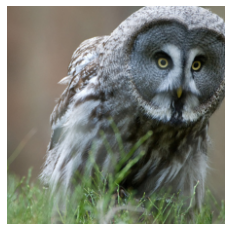

In [26]:
user.plot(true_user_data)

### Reconstruct user data:

In [39]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False)

| It: 1 | Rec. loss: 1.3943 |  Task loss: 8.0368 | T: 0.12s
Optimal condidate solution with rec. loss 0.9562 selected.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jonas/miniconda3/envs/dl/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


/home/jonas/miniconda3/envs/dl/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


METRICS: | MSE: 0.0816 | PSNR: 10.88 | FMSE: 1.0845e+01 | LPIPS: 1.39| R-PSNR: 12.59 | IIP-pixel: 0.00% | Label Acc: 100.00%


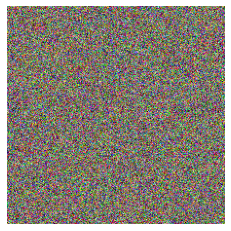

In [28]:
user.plot(reconstructed_user_data)

In [ ]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=True)

# Compare server payload to rec_models

In [29]:
param_vec = torch.cat([p.view(-1) for p in attacker.rec_models[0].parameters()])
param_vec

tensor([-0.0104, -0.0061, -0.0018,  ..., -0.0179, -0.0008, -0.0063],
       device='cuda:0', dtype=torch.float64, grad_fn=<CatBackward0>)

In [30]:
source_vec = torch.cat([p.view(-1) for p in server_payload['queries'][0]['parameters']])
user_vec =  torch.cat([p.view(-1) for p in user.model.parameters()])

In [31]:
torch.dist(param_vec, user_vec, p=float('inf'))

tensor(0., device='cuda:0', dtype=torch.float64, grad_fn=<DistBackward0>)

In [32]:
torch.dist(user_vec, source_vec, p=float('inf'))

tensor(0., device='cuda:0', grad_fn=<DistBackward0>)

# Compare pearlmutter gradient to true gradient

In [33]:
from breaching.attacks.auxiliaries.objectives import CosineSimilarity, PearlmutterCosine

In [34]:
loss_true = CosineSimilarity()
loss_true.initialize(attacker.loss_fn, cfg.attack.impl)

In [35]:
# model, gradient_data, candidate, labels
dtype = torch.float64
candidate = reconstructed_user_data['data'].detach().clone().requires_grad_().to(dtype=dtype)
gradient_data = [g.to(dtype=dtype) for g in shared_data['gradients'][0]]
labels = shared_data['labels']
user.model.to(dtype=dtype);

In [36]:
objective_value, task_loss = loss_true(user.model, gradient_data, candidate, labels)
objective_value.backward(inputs=(candidate,))
grad1 = candidate.grad.clone()

## Sanity check

In [37]:
candidate = reconstructed_user_data['data'].detach().clone().requires_grad_().to(dtype=dtype)
objective_value2, task_loss2 = loss_true(user.model, gradient_data, candidate, labels)
objective_value2.backward(inputs=(candidate,))
grad2 = candidate.grad.clone()

In [38]:
torch.dist(grad1, grad2)

tensor(8.7271e-18, device='cuda:0', dtype=torch.float64)

## Pearlmutter check:

In [16]:
import matplotlib.pyplot as plt

In [50]:
x, y, z  = [], [], []
for eps in torch.logspace(16, -16, 16**2):
    loss_pm = PearlmutterCosine(eps=eps, implementation='forward')
    loss_pm.initialize(attacker.loss_fn, cfg.attack.impl)
    
    candidate = torch.randn((10, 3, 224, 224)).requires_grad_().to(device=setup['device'],dtype=dtype)
    candidate.grad = torch.zeros_like(candidate)
    
    objective_value, task_loss = loss_true(user.model, gradient_data, candidate, labels)
    objective_value.backward(inputs=(candidate,))
    grad1 = candidate.grad.clone()
    candidate.grad = torch.zeros_like(candidate)
    
    objective_value3, task_loss3 = loss_pm(user.model, gradient_data, candidate, labels.repeat(10))
    grad3 = candidate.grad.clone()
    x.append(eps.item())
    y.append(torch.dist(grad1, grad3).item())
    z.append(((grad1.sign() - grad3.sign()).abs() > 0).float().mean().item())    

ValueError: Expected input batch_size (10) to match target batch_size (1).

In [ ]:
plt.loglog(x,y)

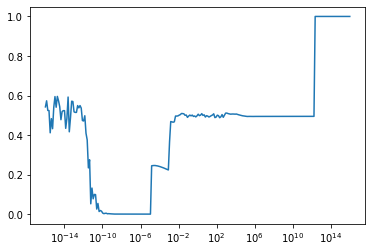

In [19]:
plt.semilogx(x, z)

## And for the Euclidean?

In [ ]:
from breaching.attacks.auxiliaries.objectives import Euclidean, PearlmutterEuclidean

In [ ]:
loss_true = Euclidean()
loss_true.initialize(attacker.loss_fn, cfg.attack.impl)

In [ ]:
candidate = reconstructed_user_data['data'].detach().clone().requires_grad_().to(dtype=dtype)
objective_value2, task_loss2 = loss_true(user.model, gradient_data, candidate, labels)
objective_value2.backward(inputs=(candidate,))
grad2 = candidate.grad.clone()

In [ ]:
x, y = [], []
for eps in torch.logspace(1, -16, 16**2):
    loss_pm = PearlmutterEuclidean(eps=eps, implementation='forward')
    loss_pm.initialize(attacker.loss_fn, cfg.attack.impl)
    
    candidate = reconstructed_user_data['data'].clone().requires_grad_().to(dtype=dtype)
    candidate.grad = torch.zeros_like(candidate)
    objective_value3, task_loss3 = loss_pm(user.model, gradient_data, candidate, labels)
    grad3 = candidate.grad.clone()
    x.append(eps.item())
    y.append(torch.dist(grad2, grad3).item())
    

In [ ]:
plt.loglog(x,y)